# Using Probability Distributions as Parameters

In most cases, augmentation that employs simple uniform distributions is enough to produce good results. E.g. in the case of rotation via affine transormations, one could provide a uniform distribution `(-30, 30)`, which would lead to images being rotated by a random value between `-30` degrees and `+30` degrees. In `imgaug`, using uniform distributions can usually be achieved via tuples, e.g. `Affine(rotate=(-30, 30))`. This pattern is supported by most augmenters. Similarly, scalar values can be used to avoid stochasticity (e.g. `Affine(rotate=-30)` will always rotate by `-30` degrees) and lists can be used to sample random values from a predefined set of valid values (e.g. `Affine(rotate=[-30, -15])` will always rotate by either `-30` degrees or `-15` degrees).

Sometimes it can be sensible to use probability distributions that differ from the described ones. For instance, one might want to rotate images by a value sampled from a gaussia or laplace distribution. For these use cases, the parameters in `imgaug.parameters` exist. After instantiating one of these, they can be used instead of the above described scalar values, tuples or lists. E.g. `Affine(rotate=imgaug.parameters.Normal(0, 5.0))` would rotate images by a value sampled from the gaussian distribution `N(0, 5.0)`. Similar parameters exist for many common probability distributions, such as Laplace, Poisson, Beta or Truncted Normal distributions.

Probability distributions available in `imgaug.parameters` are (their interfaces are largely identical to the ones in [numpy.random](https://docs.scipy.org/doc/numpy-1.15.4/reference/routines.random.html)):
* `Deterministic(value)` (mixed): Always returns `value`, i.e. is not stochastic.
* `DeterministicList(values)` (mixed): Fills the output array by iterating over `values`. If the end of `values` is reached, it restarts again at the first component of `values`.
* `Choice(a, replace=True, p=None)` (mixed): Always returns one of the values in `a`.
* `Binomial(p)` (discrete)
* `DiscreteUniform(a, b)` (discrete)
* `Poisson(lam)` (discrete)
* `Normal(loc, scale)` (continuous)
* `TruncatedNormal(loc, scale, low=-inf, high=+inf)` (continuous)
* `Laplace(loc, scale)` (continuous)
* `ChiSquare(df)` (continuous)
* `Weibull(a)` (continuous)
* `Uniform(a, b)` (continuous)
* `Beta(alpha, beta)` (continuous)

`imgaug.parameters` also contains some "helper" parameters. These wrap other parameters (e.g. one of the probability distributions above) and modify the sampled values.
* `FromLowerResolution(other_param, size_percent=None, size_px=None, method="nearest", min_size=1)`: A parameter intended for cases when random values are sampled in 2D shape, i,e, `(height, width)` or `(height, width, channels)`. In these cases, this parameter will change the sampling shape and instead sample from a lower resolution grid and then upscale. This can lead to coarser sampled values.
* `Clip(other_param, minval=None, maxval=None)`: Similar to `numpy.clip()`.
* `Discretize(other_param)`: Converts outputs of `other_param` to integers (includes rounding).
* `Absolute(other_param)`: Takes the absolute value of all parameters sampled from `other_param`.
* `RandomSign(other_param, p_positive=0.5)`: Mixes up the signs, so that roughly `p_positive` of all values end up being positive values.
* `ForceSign(other_param, positive, mode="reroll", reroll_count_max=2)`: Assures that all values sampled from `other_param` are either positive (`positive=True`) or negative (`positive=False`). This is either done using a naive sign flip (`mode="invert"`) or by re-rolling values with undesired signs up to `reroll_count_max` times until they match the desired sign (after `reroll_count_max` times the parameter falls back to `mode="invert"`).
* `Positive(other_param, mode="reroll", reroll_count_max=2)`: Shortcut for `ForceSign(..., positive=True, ...)`.
* `Negative(other_param, mode="reroll", reroll_count_max=2)`: Shortcut for `ForceSign(..., positive=False, ...)`.

There are also a few arithmetic parameters. While these can be used, stochastic parameters also support arithmetic operators. E.g. `Add(Normal(0, 2), 5)` is the same as `Normal(0, 2) + 5` and will effectively lead to values sampled from `N(5, 2)`. The arithmetic parameters are listed below. In all cases, both `other_param` and `val` are expected to be stochastic parameters or scalar values. If `elementwise` is set to `False`, then only one value will be sampled from `val`, otherwise as many as there are in `other_param`.
* `Multiply(other_param, val, elementwise=False)`
* `Divide(other_param, val, elementwise=False)`
* `Add(other_param, val, elementwise=False)`
* `Subtract(other_param, val, elementwise=False)`
* `Power(other_param, val, elementwise=False)`

Lastly, there are noise related parameters. These deal with generating or modifying noise masks, i.e. usually 2D arrays with random values between `0.0` and `1.0`.
* `IterativeNoiseAggregator(other_param, iterations=(1, 3), aggregation_method=["max", "avg"])`: Generates a few noise masks via `other_param` and combines them using an aggregation method.
* `Sigmoid(other_param, threshold=(-10, 10), activated=True)`: Applies a sigmoid function to a noise mask, making some values more pronounced than others.
* `SimplexNoise(size_px_max=(2, 16), upscale_method=["linear", "nearest"])`: Generates noise using a simplex noise method.
* `FrequencyNoise(exponent=(-4, 4), size_px_max=(4, 32), upscale_method=["linear", "nearest"])`: Generates noise by putting more or less weight on some components in frequency space.

For more details about each of the listed parameters, see the [API](https://imgaug.readthedocs.io/en/latest/source/api_parameters.html).

# Creating and Using Stochastic Parameters

Let's now start using some stochastic parameters. First, we take a look at the automatic conversion from augmenter inputs to parameters. As mentioned initially, scalar values are interpreted as non-stochastic/deterministic values (and become `imgaug.parameters.Deterministic`), tuples of form `(a, b)` are usually interpreted as uniform distributions (and become `imgaug.parameters.Uniform` or `imgaug.parameters.DiscreteUniform`) and lists are interpreted as sets of values to sample from (and become `imgaug.parameters.choice`).

The example below creates an augmenter `Multiply` and uses once a scalar value, once a tuple and once a list. As the printed messages show, these inputs are automatically converted to stochastic parameters.

In [1]:
import numpy as np
import imgaug as ia
from imgaug import augmenters as iaa
from imgaug import parameters as iap
%matplotlib inline
np.set_printoptions(precision=2, linewidth=125, suppress=False)
ia.seed(1)

aug = iaa.Multiply(mul=1)
print(aug.mul)

aug = iaa.Multiply(mul=(0.5, 1.5))
print(aug.mul)

aug = iaa.Multiply(mul=[0.5, 1.0, 1.5])
print(aug.mul)

Deterministic(int 1)
Uniform(Deterministic(float 0.50000000), Deterministic(float 1.50000000))
Choice(a=[0.5, 1.0, 1.5], replace=True, p=None)


Instead of using the automatic conversion, one can also directly provide a stochastic parameter, e.g. a deterministic value:

In [2]:
aug = iaa.Multiply(mul=iap.Deterministic(1))
print(aug.mul)

Deterministic(int 1)


All stochastic parameters offer a method `draw_samples(size, [random_state])`, which can be used to sample random values from the parameter. The resulting array has shape `size`. Note that `random_state` is quite tolerant and also accepts integer seeds. The below example shows the usage with `Deterministic`, which always produces the same output:

In [3]:
print(iap.Deterministic(1).draw_samples(10))
print(iap.Deterministic(1).draw_samples(10, random_state=1))
print(iap.Deterministic(1).draw_samples(10, random_state=1))
print(iap.Deterministic(1).draw_samples(10, random_state=2))

[1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]


`DeterministicList` can be used if a sequence of multiple values are supposed to be deterministically sampled:

In [4]:
print(iap.DeterministicList([1, 2, 3]).draw_samples(10))
print(iap.DeterministicList([1, 2, 3]).draw_samples(10, random_state=1))
print(iap.DeterministicList([1, 2, 3]).draw_samples(10, random_state=1))
print(iap.DeterministicList([1, 2, 3]).draw_samples(10, random_state=2))

[1 2 3 1 2 3 1 2 3 1]
[1 2 3 1 2 3 1 2 3 1]
[1 2 3 1 2 3 1 2 3 1]
[1 2 3 1 2 3 1 2 3 1]


The same example using `Uniform`:

In [5]:
print(iap.Uniform(0, 1.0).draw_samples(10))
print(iap.Uniform(0, 1.0).draw_samples(10, random_state=1))
print(iap.Uniform(0, 1.0).draw_samples(10, random_state=1))
print(iap.Uniform(0, 1.0).draw_samples(10, random_state=2))

[0.83 0.83 0.88 0.29 0.2  0.79 0.34 0.31 0.83 0.56]
[0.43 0.76 0.83 0.83 0.88 0.29 0.2  0.79 0.34 0.31]
[0.43 0.76 0.83 0.83 0.88 0.29 0.2  0.79 0.34 0.31]
[0.89 0.09 0.61 0.64 0.33 0.8  0.19 0.1  0.01 0.7 ]


The same example using `Choice`, which samples values by picking randomly from a set of allowed values:

In [6]:
print(iap.Choice([0, 0.5, 1.0]).draw_samples(10))
print(iap.Choice([0, 0.5, 1.0]).draw_samples(10, random_state=1))
print(iap.Choice([0, 0.5, 1.0]).draw_samples(10, random_state=1))
print(iap.Choice([0, 0.5, 1.0]).draw_samples(10, random_state=2))

[0.5 0.5 0.  0.5 0.  1.  0.  0.5 0.  1. ]
[0.5 1.  0.5 0.5 0.5 0.5 1.  1.  1.  1. ]
[0.5 1.  0.5 0.5 0.5 0.5 1.  1.  1.  1. ]
[0.5 1.  0.  0.  0.  1.  0.  0.  0.5 0.5]


`size` in `draw_samples(size, ...)` can be a scalar value or a tuple of values representing an array shape:

In [7]:
print(iap.Binomial(p=0.5).draw_samples(4*4, random_state=1))
print(iap.Binomial(p=0.5).draw_samples((4, 4), random_state=1))

[0 0 1 1 1 1 0 0 1 0 0 1 1 0 1 1]
[[0 0 1 1]
 [1 1 0 0]
 [1 0 0 1]
 [1 0 1 1]]


As mentioned at the start of the document, stochastic parameters support basic arithmetic operators:

In [8]:
print((iap.Deterministic(1) + 1).draw_samples(10))
print((iap.Deterministic(1) - 1).draw_samples(10))
print((iap.Deterministic(1) / 2).draw_samples(10))
print((iap.Deterministic(1) * 2).draw_samples(10))
print((iap.Deterministic(1) ** 2).draw_samples(10))

[2 2 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0]
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
[2 2 2 2 2 2 2 2 2 2]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


The arithmetic operators can also be used with more complex probability distributions:

In [9]:
print(iap.Choice([1, 2, 3]).draw_samples(10))
print((iap.Choice([1, 2, 3]) * 2).draw_samples(10))

[1 1 2 2 3 3 2 3 3 1]
[6 6 6 2 4 2 2 2 2 2]


Performing arithmetic operations with stochastic parameters returns multiple parameters that are wrapped in an arithmetic parameter, i.e. `param1 + param2 = Add(param1, param2)`:

In [10]:
print(iap.Choice([1, 2, 3]) * 2)

Multiply(Choice(a=[1, 2, 3], replace=True, p=None), Deterministic(int 2), False)


This detail must be kept in mind when calling the result with a `random_state` argument, as it will provide a random state -- in the above example -- to `Multiply`, which then derives two new random states from the initial one and provides them to the first and second parameter. These two derived random states are different from the initial random state. As a result `param1.draw_samples(1, np.random.RandomState(1))` can lead to different sampled values than `(param1 + 0).draw_samples(1, np.random.RandomState(1))`.

# Discrete Random Variables

Most of the examples above used either continuous probability distributions, which return float values, or mixed ones, which return data of various types. There are also three discrete probability distributions available, which return integer values:

In [11]:
print(iap.DiscreteUniform(0, 3).draw_samples(20))
print(iap.Binomial(p=0.3).draw_samples(20))
print(iap.Poisson(lam=1).draw_samples(20))

[2 1 2 1 2 1 2 2 1 1 2 2 3 0 3 3 1 3 2 0]
[0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0]
[1 0 0 0 2 2 1 0 0 1 1 0 2 2 2 3 0 4 0 2]


Any continuous probability distribution can be turned into a discrete one using `Discretize`, which rounds float values and then converts them to the nearest integers:

In [12]:
print("Continuous:", iap.Normal(0.0, 1.0).draw_samples(20))
print("Discrete:  ", iap.Discretize(iap.Normal(0.0, 1.0)).draw_samples(20))

Continuous: [-0.43  1.47  0.   -2.34 -0.5  -1.33 -2.66  0.64  0.41  0.29  0.19 -0.72 -1.61  2.14 -0.43  0.6   1.78  0.29 -1.46 -0.45]
Discrete:   [ 1 -1 -1  0  0 -2 -1 -1  1  0  0  0  0 -2  0 -1 -1  1 -2  1]


# Clip

In case you have to limit the value range of a probability distribution, `Clip` can be used, which behaves similarly to numpy's `clip` function:

In [13]:
uniform = iap.Uniform(-2, 2)
print(uniform.draw_samples(15))
print(iap.Clip(uniform, -1, None).draw_samples(15))
print(iap.Clip(uniform, None, 1).draw_samples(15))
print(iap.Clip(uniform, -1, 1).draw_samples(15))

[-0.02 -1.1  -0.7  -0.38 -1.43 -0.15  0.46 -0.09  0.95  1.99 -0.11 -0.47  1.19 -1.4  -1.16]
[ 0.96  0.11 -0.49  1.93 -1.   -1.   -1.   -0.14 -1.    0.26  1.96  0.92 -0.97  1.    1.39]
[ 1.   -0.09 -1.97 -0.51 -0.94  1.   -0.96 -0.9  -1.25  1.    0.38  0.11 -1.62  1.   -0.45]
[ 1.    1.   -0.91  0.1  -0.25  1.   -1.   -0.1   0.94 -0.64 -1.    0.27  0.3  -0.45 -0.5 ]


Note however that `Clip` can result in distorted probability densities due to all values below/above the defined minimum/maximum being projected onto the minimum/maximum value. The following plot uses a histogram to visualize the probability density after applying `Clip` to `Uniform`:

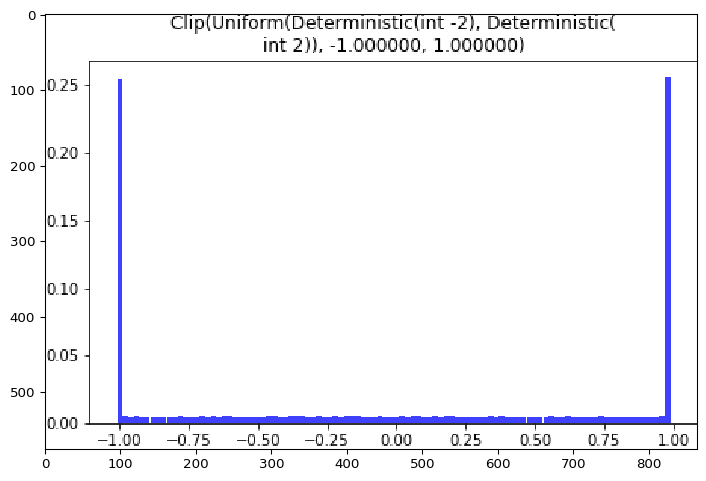

In [14]:
plot = iap.Clip(uniform, -1, 1).draw_distribution_graph()
plot_large = ia.imresize_single_image(plot, 2.0)
ia.imshow(plot_large)

# Changing signs

Several helper parameters exist to modify the sign of samples random values. The easiest way to flip signs is simple arithmetic, here used to turn the positive samples from a poisson distribution to negative ones:

In [15]:
print(iap.Poisson(lam=1).draw_samples(20))
print((-1) * iap.Poisson(lam=1).draw_samples(20))

[1 1 1 2 0 1 0 0 1 0 1 1 0 1 2 1 0 0 1 0]
[-2  0  0 -1 -1  0 -2  0 -1  0 -3  0  0 -3 -1 -2  0  0  0 -1]


In case you only want positive values, `Absolute` can be used, here applied to a gaussian distribution:

In [16]:
print(iap.Normal(0, 1.0).draw_samples(15))
print(iap.Absolute(iap.Normal(0, 1.0)).draw_samples(15))

[-0.37 -1.29  0.47  0.84  1.3   0.4   1.72  0.94  0.12  0.35 -1.78 -0.67 -0.16 -0.85 -1.94]
[0.44 0.35 1.24 0.6  0.46 0.33 0.14 0.22 0.02 0.4  0.95 0.75 0.82 1.19 0.28]


To force a specific fraction of random samples to have positive signs, the helper `RandomSign(param, p_positive)` can be used. It first turns all values to positive ones and then flips the sign of `(1-p_positive)` percent.

In [17]:
rnd_sign = iap.RandomSign(iap.Normal(0, 1.0), p_positive=0.8)
print("15 random samples: ", rnd_sign.draw_samples(15))
print("Positive samples in 10000 random samples: ", np.sum(rnd_sign.draw_samples(10000) > 0))

15 random samples:  [ 5.04e-01  1.19e+00  1.24e-01  2.13e+00  1.28e-03  1.18e+00  9.62e-01 -1.40e-02 -1.17e-01  8.48e-01  9.82e-01  4.78e-01
  1.09e+00  2.77e-01  6.09e-01]
Positive samples in 10000 random samples:  7956


Another helper is `ForceSign`, which has two arguments: `positive`, which controls whether the output values are supposed to have positive or negative signs, and `mode`, which controls how the signs are flipped. Using `mode="invert"` results in naively flipping signs by multiplying with `-1`, which can distort the probability distribution and lead to density in value ranges where there was previously no density. `mode="reroll"` will re-sample only values with wrong signs and will therefore keep the density of the probability distribution unchanged (except for the removal of positive/negative values).

In [18]:
force_sign_invert = iap.ForceSign(iap.Choice([-2, -1, 5, 10]), positive=False, mode="invert")
force_sign_reroll = iap.ForceSign(iap.Choice([-2, -1, 5, 10]), positive=False, mode="reroll")
print(force_sign_invert.draw_samples(15))
print(force_sign_reroll.draw_samples(15))

[ -2  -2  -5 -10  -2 -10  -5  -5  -2  -2  -1  -1  -2  -1 -10]
[-2 -1 -1 -1 -2 -2 -1 -1 -1 -1 -2 -1 -2 -2 -1]


The below example generates a plot using `ForceSign` with naive `mode="invert"` applied to a gaussian distribution. All negative values are simply flipped, leading to more probability density in the interval `[0, 4]` than in `[4, 8]`.

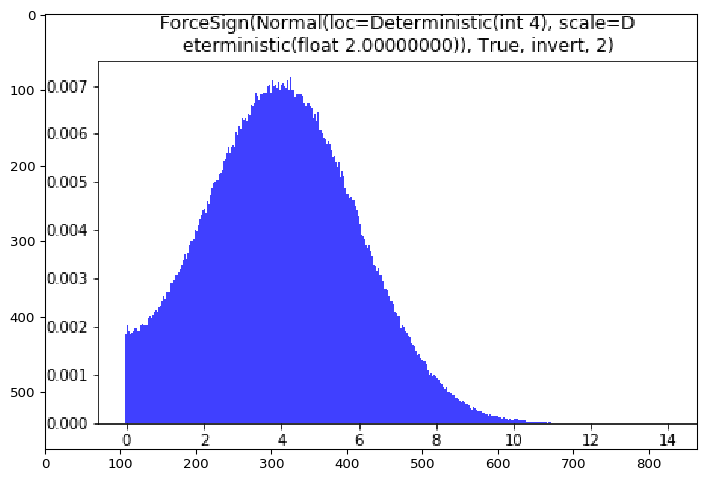

In [19]:
param = iap.ForceSign(iap.Normal(4, 2.0), positive=True, mode="invert")
plot = param.draw_distribution_graph(bins=400)
plot_large = ia.imresize_single_image(plot, 2.0)
ia.imshow(plot_large)

(Note that white vertical lines in the plot seem to be interpolation artifacts in the plotting / image generation.)

Using instead `mode="reroll"` leads to the same probability density for `[0, 4]` and `[4, 8]`:

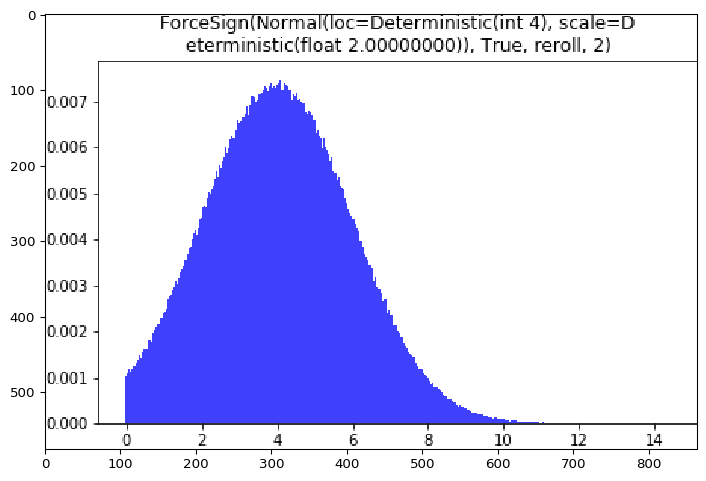

In [20]:
param = iap.ForceSign(iap.Normal(4, 2.0), positive=True, mode="reroll")
plot = param.draw_distribution_graph(bins=400)
plot_large = ia.imresize_single_image(plot, 2.0)
ia.imshow(plot_large)

The helpers `Positive()` and `Negative()` are shortcuts for `ForceSign(positive=True)` and `ForceSign(positive=False)`. Example for `Positive`:

In [21]:
positive_invert = iap.Positive(iap.Choice([-2, -1, 5, 10]), mode="invert")
positive_reroll = iap.Positive(iap.Choice([-2, -1, 5, 10]), mode="reroll")
print(positive_invert.draw_samples(15))
print(positive_reroll.draw_samples(15))

[ 2 10  5  2 10  2  1  5  1  2  5  1  5  5 10]
[ 5 10  5  5  1 10  5 10  5  5  5  2 10 10 10]


# Combining Probability Distributions

`imgaug` allows to combine probability distributions. The example below shows one of these cases, where a the `loc` (i.e. mean) hyperparameter of a gaussian distribution is not a scalar value, but instead a probability distribution of its own, in this case a `Choice`. This produces a gaussian-like distribution with two peaks instead of one. Note here though, that a mean-value is sampled from `Choice` once per call to `Normal.draw_samples()`. Hence, `Normal.draw_samples(1000 * 1000)` will lead to a very different probability distribution than one million calls of `Normal.draw_samples(1)`.

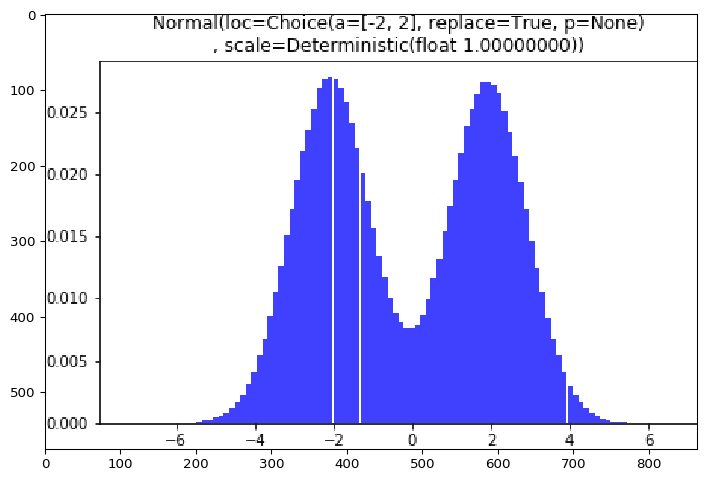

In [22]:
param = iap.Normal(iap.Choice([-2, 2]), 1.0)
plot = param.draw_distribution_graph()
plot_large = ia.imresize_single_image(plot, 2.0)
ia.imshow(plot_large)

`Choice` can also be used to combine multiple probability distributions. By using it, one can sometimes sample from one distribution and sometimes from another. (This is however quite a bit slower than sampling from each distribution on its own.)

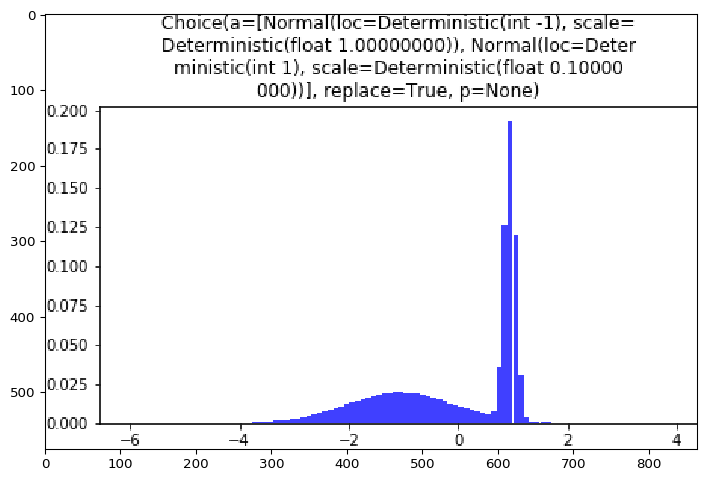

In [23]:
param = iap.Choice([iap.Normal(-1, 1.0), iap.Normal(1, 0.1)])
plot = param.draw_distribution_graph()
plot_large = ia.imresize_single_image(plot, 2.0)
ia.imshow(plot_large)

# CoarseSaltAndPepper

Combining several stochastic parameters with each other can lead to interesting effects and some augmenters are nothing else than wrappers around stochastic parameters and other basic augmenters (e.g. `AddElementwise` or `ReplaceElementwise`). The example below shows how to implement an augmentation function that applies a coarse form of salt and pepper like noise to an image. It replaces rectangular areas of the image with noise containing very bright and dark pixels. The rectangular mask is sampled from a `Binomial`, which is made coarse using `FromLowerResolution`. The noise is sampled from a `Beta(0.5, 0.5)` distribution, which has most of its probability density around `0.0` and `1.0`. The pixels within the masks are then replaced by the sampled noise using the `ReplaceElementwise` augmenter.

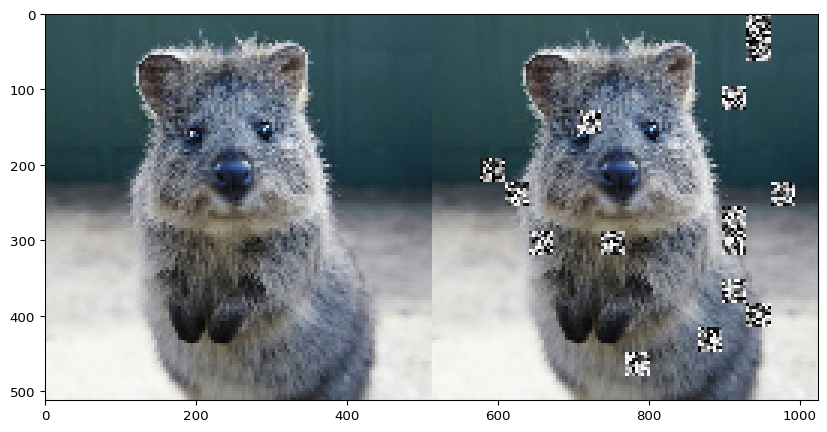

In [24]:
def apply_coarse_salt_and_pepper(image, p, size_px):
    # mask where to replace
    mask = iap.Binomial(p)
    
    # make the mask coarser
    mask_coarse = iap.FromLowerResolution(other_param=mask, size_px=size_px)

    # the noise to use as replacements, mostly close to 0.0 and 1.0
    replacement = iap.Beta(0.5, 0.5)
    
    # project noise to uint8 value range
    replacement = replacement * 255

    # replace masked areas with noise
    return iaa.ReplaceElementwise(
        mask=mask_coarse,
        replacement=replacement
    )(image=image)

image = ia.quokka_square(size=(128, 128))  # example images
image_aug = apply_coarse_salt_and_pepper(image, 0.05, 16)  # apply noise
ia.imshow(
    ia.imresize_single_image(
        np.hstack([image, image_aug]),
        4.0
    )
)